In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from scipy.stats.mstats import winsorize

# Loading the file
file = pd.read_csv("e11.csv")
main = file.copy()

# Convert all columns to numeric and coerce non-convertible values to NaN
file = file.apply(pd.to_numeric, errors='coerce')

# Function to fill missing values and zero values with the moving average for a DataFrame
def fill_missing_data(array, window_size=3, technique="smooth", **kwargs):
    n = len(array)
    filled_array = array.copy()
    
    for i in range(n):
        if np.isnan(array[i]) or array[i] == 0:
            # Find the nearest non-missing and non-zero values to the left and right
            left_index = i - 1
            right_index = i + 1
            while left_index >= 0 and (np.isnan(array[left_index]) or array[left_index] == 0):
                left_index -= 1
            while right_index < n and (np.isnan(array[right_index]) or array[right_index] == 0):
                right_index += 1
            # Apply the specified technique
            if technique == "winsorize":
                if 'winsorize_threshold' in kwargs:
                    winsorized_value = winsorize(array, limits=kwargs['winsorize_threshold'])[i]
                    filled_array[i] = winsorized_value
            elif technique == "impute":
                if 'impute_method' in kwargs:
                    if kwargs['impute_method'] == "median":
                        filled_array[i] = np.nanmedian(array)
                    elif kwargs['impute_method'] == "mean":
                        filled_array[i] = np.nanmean(array)
            elif technique == "trim":
                if 'trim_threshold' in kwargs:
                    z_score = np.abs(array[i] - np.nanmedian(array)) / np.nanstd(array)
                    if z_score > kwargs['trim_threshold']:
                        filled_array[i] = np.nan
            elif technique == "cap":
                if 'cap_max' in kwargs:
                    filled_array[i] = min(filled_array[i], kwargs['cap_max'])
                if 'cap_min' in kwargs:
                    filled_array[i] = max(filled_array[i], kwargs['cap_min'])
            elif technique == "robust_estimation":
                if 'use_robust_estimation' in kwargs and kwargs['use_robust_estimation']:
                    median = np.nanmedian(array)
                    mad = np.nanmedian(np.abs(array - median))
                    threshold = 3.0  # Adjust this threshold as needed
                    if np.abs(array[i] - median) > threshold * mad:
                        filled_array[i] = median

    # Apply moving average to the entire filled array for smoothing
    smoothed_array = filled_array.copy()
    for i in range(window_size, n - window_size):
        smoothed_array[i] = np.nanmean(filled_array[i - window_size:i + window_size + 1])

    return smoothed_array

# Specify the window size for the moving average
window_size = 5  
filled_df = file.copy()

# Apply the fill_missing_data function to the specified columns
columns_to_fill = [f'c{i}' for i in range(2, 242) if i != 240]


#1: Winsorization
winsorize_threshold = (0.05, 0.05)
for column in columns_to_fill:
    if pd.api.types.is_numeric_dtype(filled_df[column]):
        filled_df[column] = fill_missing_data(filled_df[column], window_size, technique="winsorize", winsorize_threshold=winsorize_threshold)

#2: Imputation (using the median)
for column in columns_to_fill:
    if pd.api.types.is_numeric_dtype(filled_df[column]):
        filled_df[column] = fill_missing_data(filled_df[column], window_size, technique="impute", impute_method="median")

#3: Trimming
trim_threshold = 3.0 
for column in columns_to_fill:
    if pd.api.types.is_numeric_dtype(filled_df[column]):
        filled_df[column] = fill_missing_data(filled_df[column], window_size, technique="trim", trim_threshold=trim_threshold)

#4: Capping (setting a maximum and minimum value)
cap_max = 3.0 
cap_min = -3.0
for column in columns_to_fill:
    if pd.api.types.is_numeric_dtype(filled_df[column]):
        filled_df[column] = fill_missing_data(filled_df[column], window_size, technique="cap", cap_max=cap_max, cap_min=cap_min)

#5: Robust Estimation
for column in columns_to_fill:
    if pd.api.types.is_numeric_dtype(filled_df[column]):
        filled_df[column] = fill_missing_data(filled_df[column], window_size, technique="robust_estimation", use_robust_estimation=True)

# Create individual plots for each column, including the original and filled values
for column in [f'c{i}' for i in range(2, 5) if i != 240]:
    fig = px.line(filled_df, x=filled_df.index, y=[file[column], filled_df[column]], title=f'Original and Filled {column}')
    fig.update_xaxes(title_text='Row Number')
    fig.update_yaxes(title_text=column)
    fig.show()


C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_28976\746660811.py:59: RuntimeWarning: Mean of empty slice
  smoothed_array[i] = np.nanmean(filled_array[i - window_size:i + window_size + 1])
C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_28976\746660811.py:35: RuntimeWarning: All-NaN slice encountered
  filled_array[i] = np.nanmedian(array)
C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_28976\746660811.py:40: RuntimeWarning: All-NaN slice encountered
  z_score = np.abs(array[i] - np.nanmedian(array)) / np.nanstd(array)
c:\Users\Utkarsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_28976\746660811.py:50: RuntimeWarning: All-NaN slice encountered
  median = np.nanmedian(array)
C:\Users\Utkarsh\AppData\Local\Temp\ipykernel_28976\746660811.py:51: RuntimeWarning: All-NaN slice encountered
  mad 

In [2]:
file = filled_df.copy()
file

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c231,c232,c233,c234,c235,c236,c237,c238,c239,c241
0,NaN,2,164.154800,155.467568,0.707847,1.227071,2.264965,18.978886,7.561194,0.719497,...,27.213851,27.100483,25.783700,25.145290,0.670200,68.098119,66.492249,32.753858,42.811412,2.184083
1,NaN,2,162.115737,153.645223,0.454140,0.671909,2.260011,18.639050,7.844962,0.702348,...,27.213851,27.100483,25.783700,25.145290,0.671396,68.027155,66.519557,33.338342,42.915315,2.233879
2,NaN,2,153.718388,142.880092,0.634565,0.683161,2.085850,16.671939,6.708392,0.656799,...,27.213851,27.100483,25.783700,25.145290,0.672458,67.502954,66.114777,36.442830,42.981814,2.088296
3,NaN,2,169.214952,157.342985,0.646557,0.722743,2.258069,17.871757,7.239110,0.662394,...,27.213851,27.100483,25.783700,25.145290,0.670275,68.202787,65.257423,38.454676,43.168207,2.089270
4,NaN,2,176.335010,163.307519,0.683941,0.681609,2.252392,18.591802,7.257898,0.689549,...,27.213851,27.100483,25.783700,25.145290,0.669760,68.254780,65.940144,40.601255,43.445943,2.096676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,NaN,2,170.995057,165.998017,0.610354,2.492540,2.150980,19.448113,8.506249,0.577761,...,27.423187,27.447340,26.236872,25.355602,0.696125,68.027026,70.065016,39.780049,38.551735,1.957681
1021,NaN,2,171.841123,166.840518,0.335817,2.580334,2.145125,19.449504,8.916708,0.585410,...,27.515604,27.473610,26.253992,25.340651,0.694272,67.947152,69.785727,38.035531,40.965092,1.986429
1022,NaN,2,173.074392,168.084249,0.368131,2.711153,2.149443,19.411187,9.235679,0.586067,...,27.514629,27.480869,26.255411,25.313704,0.693788,67.908717,69.540714,37.499035,41.278392,2.006031
1023,NaN,2,173.254503,168.244718,0.461550,2.724708,2.144927,19.426058,9.236836,0.583313,...,27.554869,27.514990,26.290037,25.328732,0.692648,67.883204,69.423670,37.503065,41.388672,2.020471


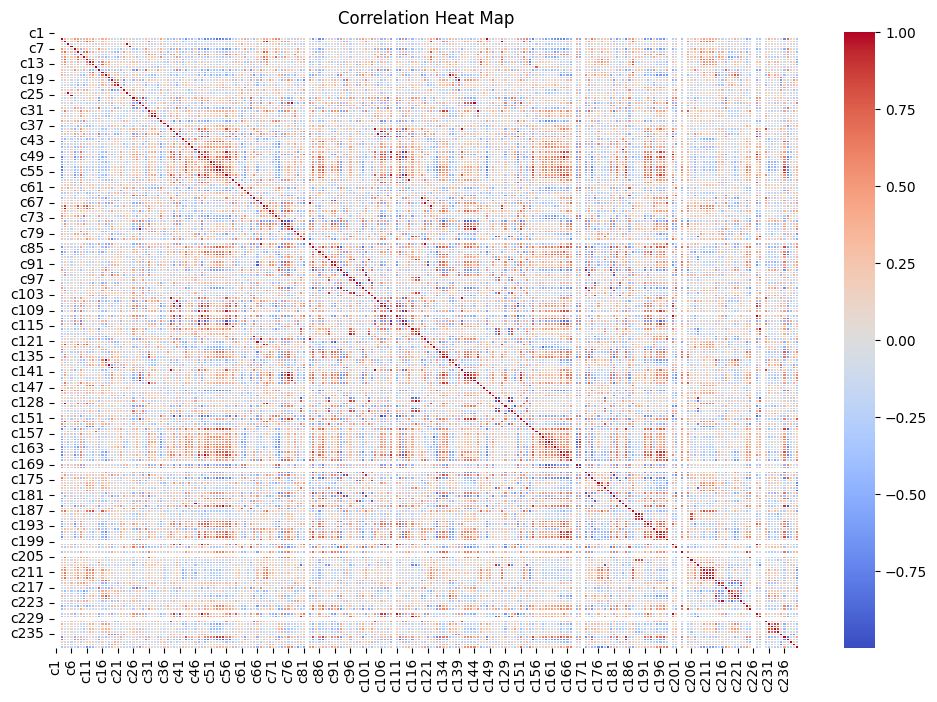

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_columns = file

# Calculate the correlation matrix
correlation_matrix = selected_columns.corr()

# Plot the heatmap without the numerical values inside the boxes
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=.5, )
plt.title('Correlation Heat Map')
plt.show()

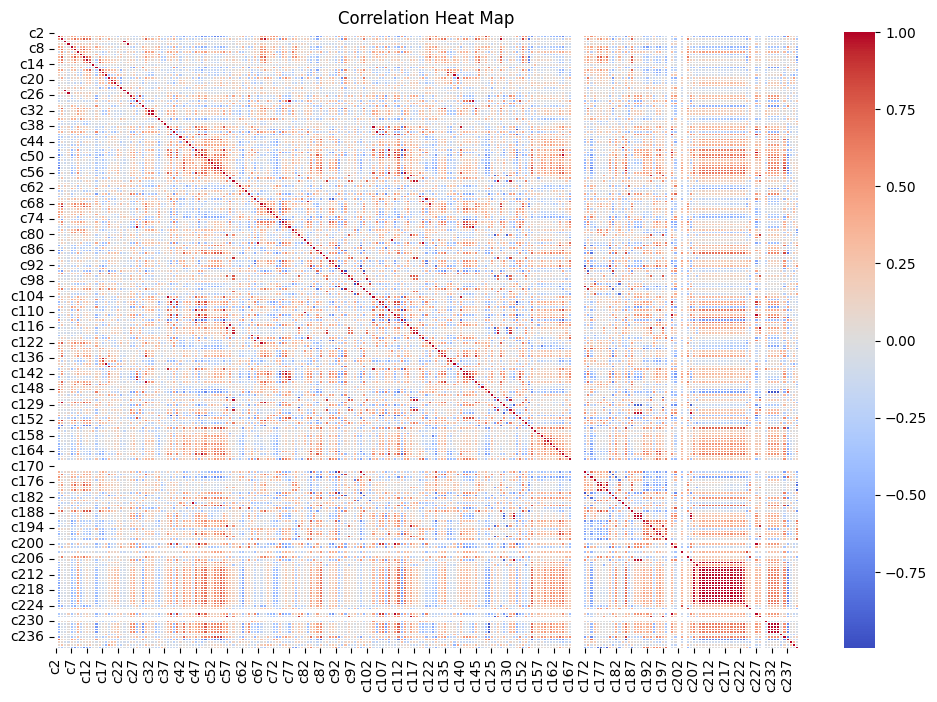

In [4]:
main2 = main.apply(pd.to_numeric, errors='coerce')

# Specify the columns to fill NaN values
columns_to_fill = main2.drop("c1", axis=1)
main2.fillna(0, inplace=True)
for column in columns_to_fill:
    main2[column].fillna(main2[column].mean(), inplace=True)

selected_columns = main2.drop("c1", axis = 1)

# Calculate the correlation matrix
correlation_matrix = selected_columns.corr()

# Plot the heatmap without the numerical values inside the boxes
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=.5, )
plt.title('Correlation Heat Map')
plt.show()

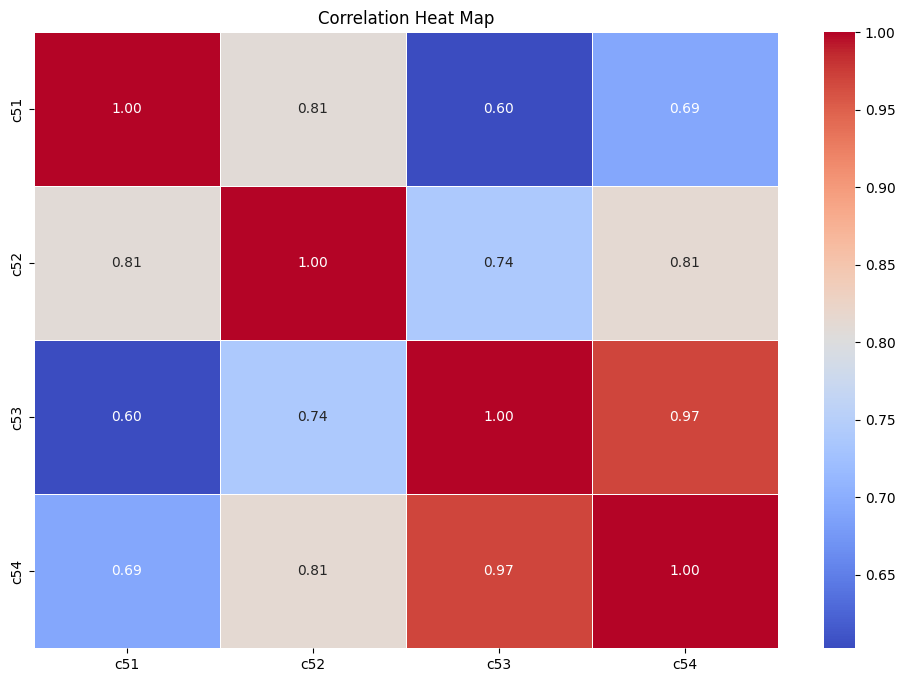

In [5]:
# Select specific columns for correlation analysis
selected_columns = file[["c51","c52","c53","c54"]]


correlation_matrix = selected_columns.corr()

# Plot the heatmap with the numerical values inside the boxes
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, )
plt.title('Correlation Heat Map')
plt.show()


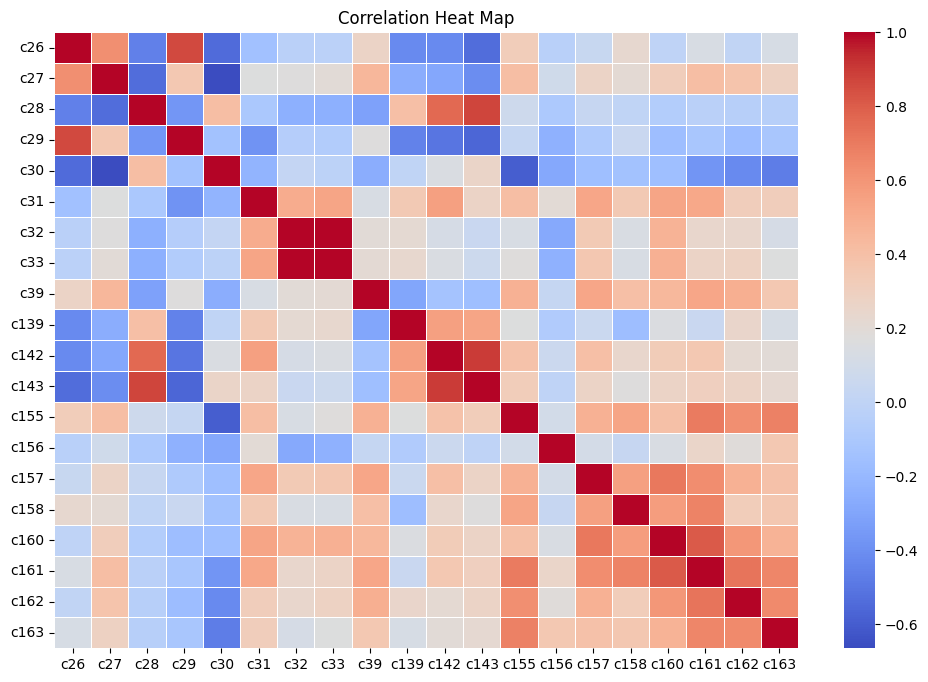

In [31]:
# Select specific columns for correlation analysis
selected_columns = file[["c26", "c27", "c28", "c29", "c30", "c31", "c32", "c33", "c39", "c139", "c142", "c143", "c155", "c156", "c157", "c158", "c160", "c161", "c162", "c163"]]

# Calculate the correlation matrix
correlation_matrix = selected_columns.corr()

# Plot the heatmap without the numerical values inside the boxes
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=.5, )
plt.title('Correlation Heat Map')
plt.show()

In [6]:
import statsmodels.api as sm

In [7]:
file = file.apply(pd.to_numeric, errors='coerce')

# Specify the columns to fill NaN values
columns_to_fill = file.drop("c1", axis=1)
file.fillna(0, inplace=True)
for column in columns_to_fill:
    file[column].fillna(file[column].mean(), inplace=True)

In [8]:
def classify_alert_level(value):
    if value < 5:
        return "SAFE"
    elif 5 <= value <= 10:
        return "MODERATE"
    elif 10 < value <= 20:
        return "HIGH"
    else:
        return "CRITICAL"

In [9]:
def stepwise_regression(file, dependent_variable, independent_variables):
    # Define a threshold for p-values
    p_value_threshold = 0.05
    
    while True:
        # Fit a multiple linear regression model
        X = independent_variables
        X = sm.add_constant(X)
        Y = file[[dependent_variable]]
        model = sm.OLS(Y, X).fit()
        
        # Extract p-values for the independent variables
        p_values = model.pvalues[1:]  # Exclude the constant term
        
        # Find the variable with the largest p-value
        max_p_value_variable = p_values.idxmax()
        
        # Check if the largest p-value is greater than the threshold
        if p_values[max_p_value_variable] > p_value_threshold:
            # If yes, remove the variable from the common set and continue the loop
            independent_variables = independent_variables.drop(max_p_value_variable, axis=1)
        else:
            # If no, stop the loop
            break
    
    # Predict the values
    X = sm.add_constant(independent_variables)
    predicted_values = model.predict(X)
    
    # Classify the predicted values into alert levels
    alert_levels = predicted_values.apply(classify_alert_level)
    
    # Add new columns for the predicted values and alert levels in the 'file' DataFrame
    file[f"{dependent_variable}_Predicted_Values"] = predicted_values
    file[f"{dependent_variable}_Alert_Level"] = alert_levels

    # Print the final set of dependent variables with p-values in descending order
    final_dependent_variables = list(independent_variables.columns)
    final_dependent_variables.sort(key=lambda x: model.pvalues[independent_variables.columns.get_loc(x)], reverse=True)
    print(f"Final Dependent Variables for {dependent_variable} in Descending Order of Importance (Based on P-Values):")
    print(final_dependent_variables)
    # Print the model summary
    print("Model Summary for", dependent_variable)
    print(model.summary())

In [10]:
file1 = file.copy()

In [11]:
file1

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c231,c232,c233,c234,c235,c236,c237,c238,c239,c241
0,0.0,2,164.154800,155.467568,0.707847,1.227071,2.264965,18.978886,7.561194,0.719497,...,27.213851,27.100483,25.783700,25.145290,0.670200,68.098119,66.492249,32.753858,42.811412,2.184083
1,0.0,2,162.115737,153.645223,0.454140,0.671909,2.260011,18.639050,7.844962,0.702348,...,27.213851,27.100483,25.783700,25.145290,0.671396,68.027155,66.519557,33.338342,42.915315,2.233879
2,0.0,2,153.718388,142.880092,0.634565,0.683161,2.085850,16.671939,6.708392,0.656799,...,27.213851,27.100483,25.783700,25.145290,0.672458,67.502954,66.114777,36.442830,42.981814,2.088296
3,0.0,2,169.214952,157.342985,0.646557,0.722743,2.258069,17.871757,7.239110,0.662394,...,27.213851,27.100483,25.783700,25.145290,0.670275,68.202787,65.257423,38.454676,43.168207,2.089270
4,0.0,2,176.335010,163.307519,0.683941,0.681609,2.252392,18.591802,7.257898,0.689549,...,27.213851,27.100483,25.783700,25.145290,0.669760,68.254780,65.940144,40.601255,43.445943,2.096676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,0.0,2,170.995057,165.998017,0.610354,2.492540,2.150980,19.448113,8.506249,0.577761,...,27.423187,27.447340,26.236872,25.355602,0.696125,68.027026,70.065016,39.780049,38.551735,1.957681
1021,0.0,2,171.841123,166.840518,0.335817,2.580334,2.145125,19.449504,8.916708,0.585410,...,27.515604,27.473610,26.253992,25.340651,0.694272,67.947152,69.785727,38.035531,40.965092,1.986429
1022,0.0,2,173.074392,168.084249,0.368131,2.711153,2.149443,19.411187,9.235679,0.586067,...,27.514629,27.480869,26.255411,25.313704,0.693788,67.908717,69.540714,37.499035,41.278392,2.006031
1023,0.0,2,173.254503,168.244718,0.461550,2.724708,2.144927,19.426058,9.236836,0.583313,...,27.554869,27.514990,26.290037,25.328732,0.692648,67.883204,69.423670,37.503065,41.388672,2.020471


In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data_frame):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data_frame.columns
    vif_data["VIF"] = [variance_inflation_factor(data_frame.values, i) for i in range(data_frame.shape[1])]
    
    return vif_data

def remove_max_vif_column(data_frame):
    while True:
        vif_result = calculate_vif(data_frame)
        max_vif_index = vif_result["VIF"].idxmax()
        max_vif = vif_result.loc[max_vif_index, "VIF"]

        if max_vif > 10:
            # print(f"Removing variable '{vif_result.loc[max_vif_index, 'Variable']}' with VIF {max_vif}")
            data_frame = data_frame.drop(vif_result.loc[max_vif_index, 'Variable'], axis=1)
        else:
            break

    return data_frame


In [13]:
# Set of independent variables
independent_variables = file1.drop(["c51", "c52", "c53", "c54", "c1"], axis=1)
subset_size = 100
independent_variables_subset = independent_variables.iloc[:, :subset_size]

independent_variables_subset = remove_max_vif_column(independent_variables_subset)

# Print the final independent variables DataFrame
print("Independent variables after VIF-based column removal:")
print(independent_variables_subset)

# Find the common set of independent variables with p-values less than or equal to 0.05

for dependent_variable in ["c51", "c52", "c53", "c54"]:
    stepwise_regression(file1, dependent_variable, independent_variables_subset)


c:\Users\Utkarsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\Utkarsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\Utkarsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\Utkarsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\Utkarsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\Utkarsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\reg

Independent variables after VIF-based column removal:
      c2        c7         c8        c12       c14        c17       c20  \
0      2  2.264965  18.978886   7.973372  0.002228  28.334700  7.120964   
1      2  2.260011  18.639050   7.742874  0.002228  28.211453  7.793413   
2      2  2.085850  16.671939   8.287341  0.002228  28.949064  7.289157   
3      2  2.258069  17.871757   9.744850  0.000100  33.964274  7.958076   
4      2  2.252392  18.591802  10.457647  0.002229  36.744817  8.757605   
...   ..       ...        ...        ...       ...        ...       ...   
1020   2  2.150980  19.448113  11.216774  0.002229  32.960498  7.606814   
1021   2  2.145125  19.449504  11.321437  0.002229  34.780114  8.093012   
1022   2  2.149443  19.411187  11.288059  0.002229  35.304408  7.956216   
1023   2  2.144927  19.426058  11.327831  0.002229  35.601796  7.985720   
1024   2  2.144609  19.457788  11.310388  0.002229  35.675808  8.146586   

           c22        c23       c24  ...     

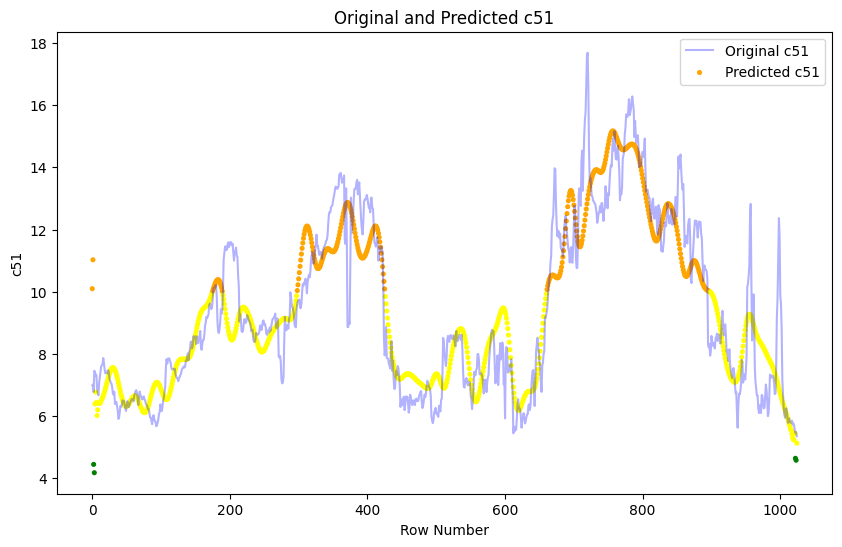

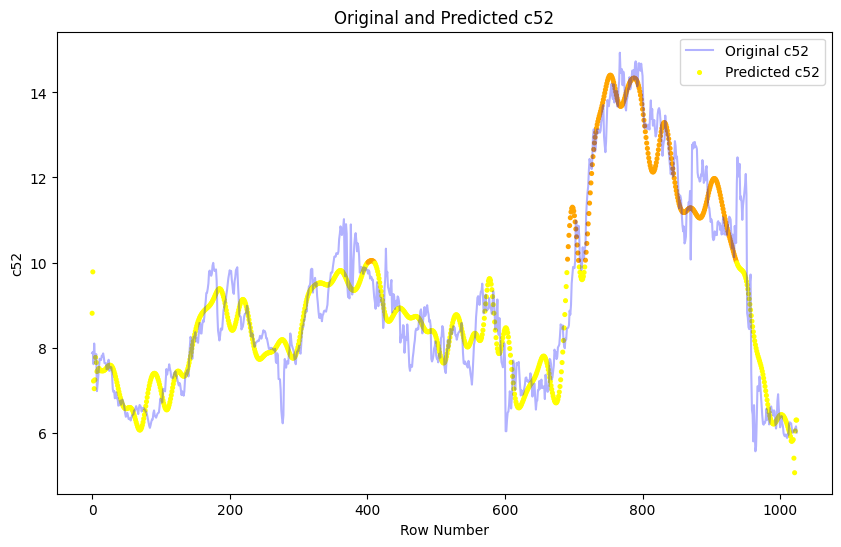

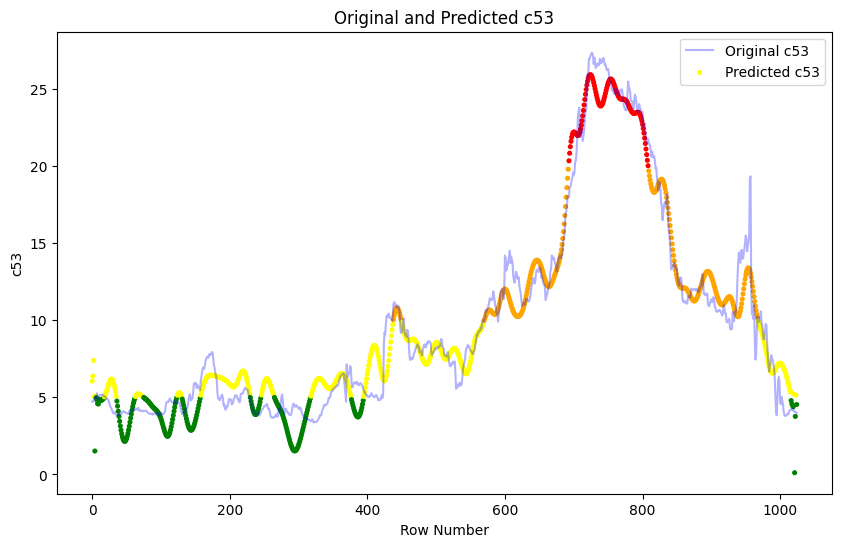

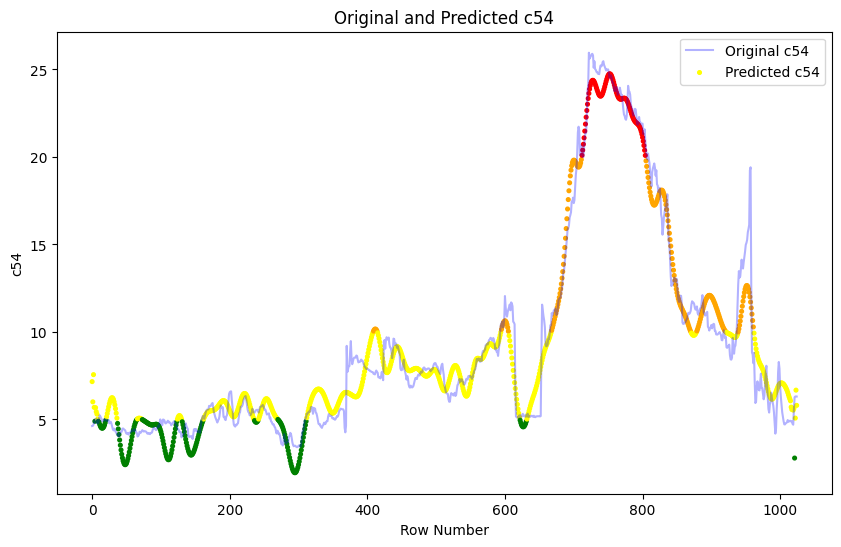

In [15]:

# Columns to plot
columns_to_plot = ["c51", "c52", "c53", "c54"]

for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    
    # Plot original values with plt.plot
    plt.plot(filled_df.index, main[column], label=f'Original {column}', color='blue', alpha=0.3)  # Use alpha to make it slightly transparent
    
    # Plot filled values with color coding using plt.scatter
    colors = []

    for val in file1[f'{column}_Predicted_Values']:
        if val < 5:
            colors.append("green")
        elif 5 <= val <= 10:
            colors.append("yellow")
        elif 10 < val <= 20:
            colors.append("orange")
        else:
            colors.append("red")

    plt.scatter(filled_df.index, file1[f'{column}_Predicted_Values'], label=f'Predicted {column}', color=colors, s=7, )  # Added edgecolors for better visibility
    plt.xlabel('Row Number')
    plt.ylabel(column)
    plt.title(f'Original and Predicted {column}')

    plt.legend()
    plt.show()

# PART 1b

In [16]:
file2 = file.copy()

In [17]:
independent_variables = file2[["c26", "c27", "c28", "c29", "c30", "c31", "c32", "c33", "c39", "c139", "c142", "c143", "c155", "c156", "c157", "c158", "c160", "c161", "c162", "c163"]]

# Find the common set of independent variables with p-values less than or equal to 0.05
for dependent_variable in ["c51", "c52", "c53", "c54"]:
    stepwise_regression(file2, dependent_variable, independent_variables)


Final Dependent Variables for c51 in Descending Order of Importance (Based on P-Values):
['c29', 'c157', 'c28', 'c156', 'c26', 'c39', 'c155', 'c27', 'c33', 'c30', 'c160', 'c32', 'c161', 'c163']
Model Summary for c51
                            OLS Regression Results                            
Dep. Variable:                    c51   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     245.0
Date:                Sun, 12 Nov 2023   Prob (F-statistic):          8.89e-313
Time:                        19:42:12   Log-Likelihood:                -1667.3
No. Observations:                1025   AIC:                             3365.
Df Residuals:                    1010   BIC:                             3439.
Df Model:                          14                                         
Covariance Type:            nonrobust                                    

In [18]:
file2

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c239,c241,c51_Predicted_Values,c51_Alert_Level,c52_Predicted_Values,c52_Alert_Level,c53_Predicted_Values,c53_Alert_Level,c54_Predicted_Values,c54_Alert_Level
0,0.0,2,164.154800,155.467568,0.707847,1.227071,2.264965,18.978886,7.561194,0.719497,...,42.811412,2.184083,5.694144,MODERATE,5.965551,MODERATE,4.545342,SAFE,4.037630,SAFE
1,0.0,2,162.115737,153.645223,0.454140,0.671909,2.260011,18.639050,7.844962,0.702348,...,42.915315,2.233879,4.435968,SAFE,5.985955,MODERATE,4.212944,SAFE,2.819349,SAFE
2,0.0,2,153.718388,142.880092,0.634565,0.683161,2.085850,16.671939,6.708392,0.656799,...,42.981814,2.088296,3.503507,SAFE,4.653049,SAFE,5.365416,MODERATE,4.911224,SAFE
3,0.0,2,169.214952,157.342985,0.646557,0.722743,2.258069,17.871757,7.239110,0.662394,...,43.168207,2.089270,6.482257,MODERATE,6.232208,MODERATE,6.417198,MODERATE,7.016328,MODERATE
4,0.0,2,176.335010,163.307519,0.683941,0.681609,2.252392,18.591802,7.257898,0.689549,...,43.445943,2.096676,7.083899,MODERATE,7.001810,MODERATE,5.867782,MODERATE,5.976491,MODERATE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,0.0,2,170.995057,165.998017,0.610354,2.492540,2.150980,19.448113,8.506249,0.577761,...,38.551735,1.957681,6.386693,MODERATE,4.989902,SAFE,6.545200,MODERATE,6.968536,MODERATE
1021,0.0,2,171.841123,166.840518,0.335817,2.580334,2.145125,19.449504,8.916708,0.585410,...,40.965092,1.986429,8.703388,MODERATE,6.223207,MODERATE,3.784444,SAFE,5.361117,MODERATE
1022,0.0,2,173.074392,168.084249,0.368131,2.711153,2.149443,19.411187,9.235679,0.586067,...,41.278392,2.006031,7.582347,MODERATE,5.491584,MODERATE,3.534937,SAFE,4.708870,SAFE
1023,0.0,2,173.254503,168.244718,0.461550,2.724708,2.144927,19.426058,9.236836,0.583313,...,41.388672,2.020471,7.257916,MODERATE,3.872120,SAFE,2.176735,SAFE,3.383798,SAFE


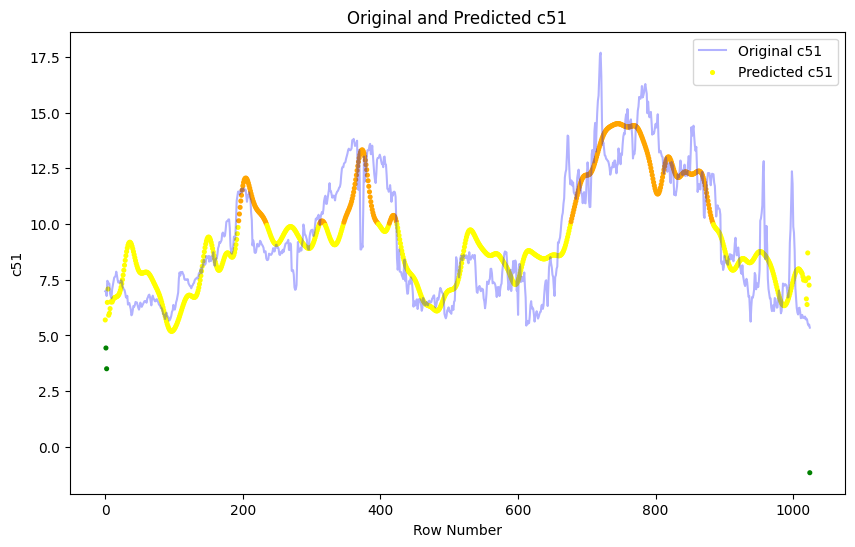

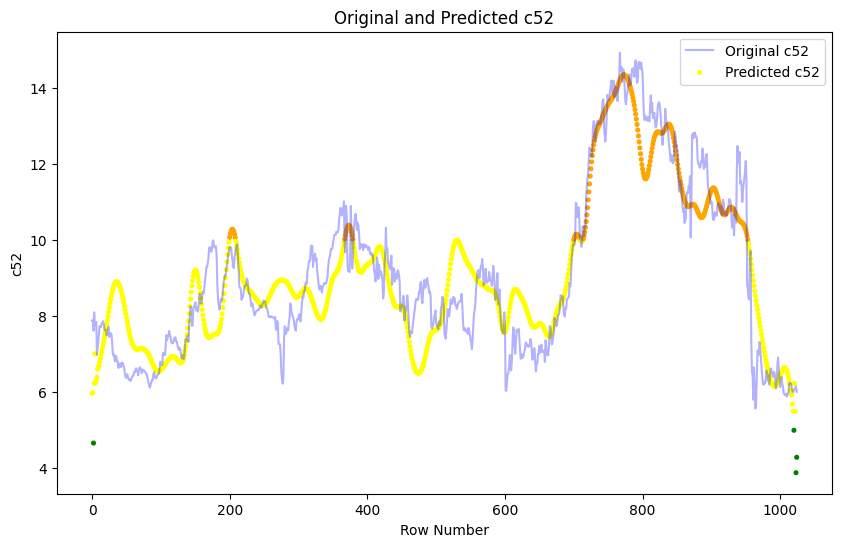

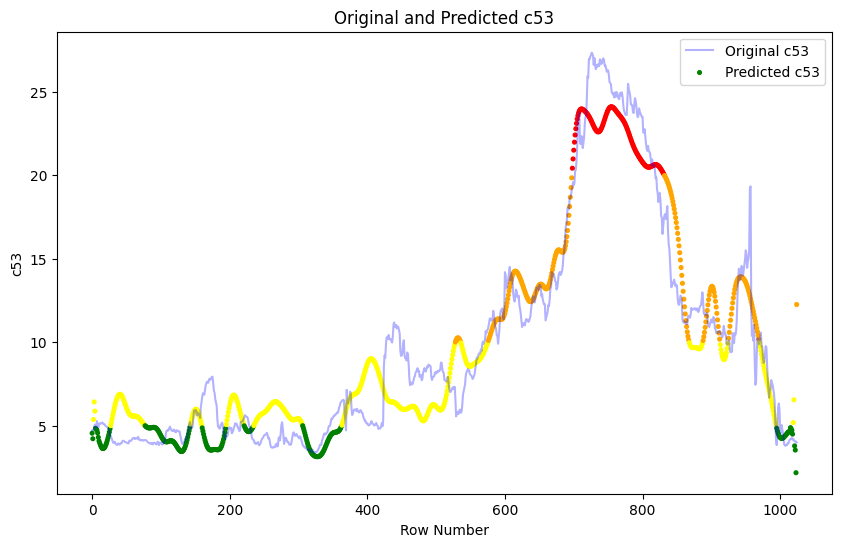

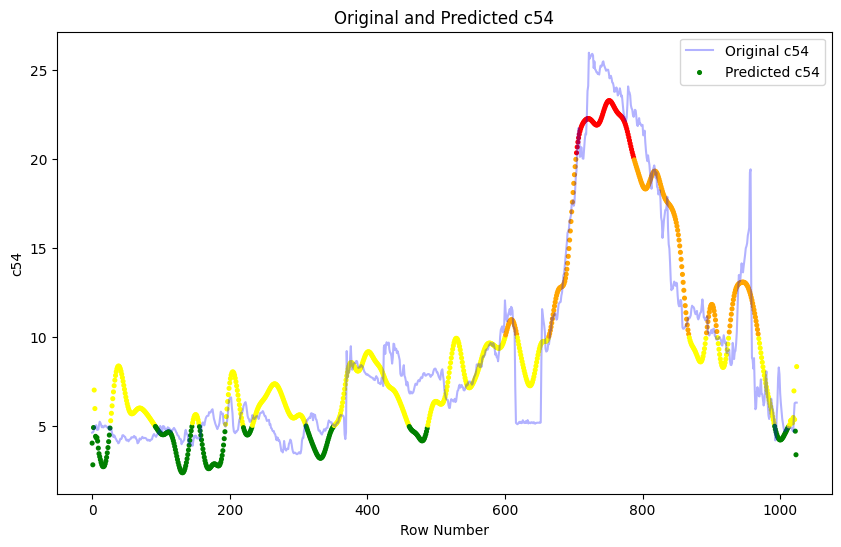

In [19]:

columns_to_plot = ["c51", "c52", "c53", "c54"]

for column in columns_to_plot:
    # Create a new figure
    plt.figure(figsize=(10, 6))
    
    plt.plot(filled_df.index, main[column], label=f'Original {column}', color='blue', alpha=0.3)  # Use alpha to make it slightly transparent
    colors = []

    for val in file2[f'{column}_Predicted_Values']:
        if val < 5:
            colors.append("green")
        elif 5 <= val <= 10:
            colors.append("yellow")
        elif 10 < val <= 20:
            colors.append("orange")
        else:
            colors.append("red")

    plt.scatter(filled_df.index, file2[f'{column}_Predicted_Values'], label=f'Predicted {column}', color=colors, s=7, )
    plt.xlabel('Row Number')
    plt.ylabel(column)
    plt.title(f'Original and Predicted {column}')
    plt.legend()
    plt.show()

# PART 3

In [20]:
file3 = file.copy()

In [21]:
def stepwise_regression2(file, dependent_variable, independent_variables):
    # Define a threshold for p-values
    p_value_threshold = 0.05
    
    while True:
        # Fit a multiple linear regression model
        X = independent_variables
        X = sm.add_constant(X)
        Y = file[[dependent_variable]]
        model = sm.OLS(Y, X).fit()
        
        # Extract p-values for the independent variables
        p_values = model.pvalues[1:]  # Exclude the constant term
        
        # Find the variable with the largest p-value
        max_p_value_variable = p_values.idxmax()
        
        # Check if the largest p-value is greater than the threshold
        if p_values[max_p_value_variable] > p_value_threshold:
            # If yes, remove the variable from the common set and continue the loop
            independent_variables = independent_variables.drop(max_p_value_variable, axis=1)
        else:
            # If no, stop the loop
            break
    
    # Predict the values
    X = sm.add_constant(independent_variables)
    predicted_values = model.predict(X)
    
    
    # Add new columns for the predicted values and alert levels in the 'file' DataFrame
    file[f"{dependent_variable}_Predicted_Values"] = predicted_values

    # Print the final set of dependent variables with p-values in descending order
    final_dependent_variables = list(independent_variables.columns)
    final_dependent_variables.sort(key=lambda x: model.pvalues[independent_variables.columns.get_loc(x)], reverse=True)
    print(f"Final Dependent Variables for {dependent_variable} in Descending Order of Importance (Based on P-Values):")
    print(final_dependent_variables)
    # Print the model summary
    print("Model Summary for", dependent_variable)
    print(model.summary())

In [22]:
# Define the set of independent variables
independent_variables = file3.drop(["c241", "c1"], axis=1)
subset_size = 100
independent_variables_subset = independent_variables.iloc[:, :subset_size]

independent_variables_subset = remove_max_vif_column(independent_variables_subset)

# Print the final independent variables DataFrame
print("Independent variables after VIF-based column removal:")
print(independent_variables_subset)

# Find the common set of independent variables with p-values less than or equal to 0.05

stepwise_regression2(file3, "c241", independent_variables_subset)


c:\Users\Utkarsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\Utkarsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\Utkarsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\Utkarsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\Utkarsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\Utkarsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\reg

Independent variables after VIF-based column removal:
      c2        c7        c12       c14        c17       c20       c22  \
0      2  2.264965   7.973372  0.002228  28.334700  7.120964  2.743170   
1      2  2.260011   7.742874  0.002228  28.211453  7.793413  2.596314   
2      2  2.085850   8.287341  0.002228  28.949064  7.289157  2.557701   
3      2  2.258069   9.744850  0.000100  33.964274  7.958076  2.897314   
4      2  2.252392  10.457647  0.002229  36.744817  8.757605  2.917772   
...   ..       ...        ...       ...        ...       ...       ...   
1020   2  2.150980  11.216774  0.002229  32.960498  7.606814  6.734358   
1021   2  2.145125  11.321437  0.002229  34.780114  8.093012  6.646485   
1022   2  2.149443  11.288059  0.002229  35.304408  7.956216  6.575772   
1023   2  2.144927  11.327831  0.002229  35.601796  7.985720  6.480572   
1024   2  2.144609  11.310388  0.002229  35.675808  8.146586  6.097910   

            c23       c24       c25  ...       c63       

In [23]:
file3

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c232,c233,c234,c235,c236,c237,c238,c239,c241,c241_Predicted_Values
0,0.0,2,164.154800,155.467568,0.707847,1.227071,2.264965,18.978886,7.561194,0.719497,...,27.100483,25.783700,25.145290,0.670200,68.098119,66.492249,32.753858,42.811412,2.184083,2.269052
1,0.0,2,162.115737,153.645223,0.454140,0.671909,2.260011,18.639050,7.844962,0.702348,...,27.100483,25.783700,25.145290,0.671396,68.027155,66.519557,33.338342,42.915315,2.233879,2.469249
2,0.0,2,153.718388,142.880092,0.634565,0.683161,2.085850,16.671939,6.708392,0.656799,...,27.100483,25.783700,25.145290,0.672458,67.502954,66.114777,36.442830,42.981814,2.088296,2.342310
3,0.0,2,169.214952,157.342985,0.646557,0.722743,2.258069,17.871757,7.239110,0.662394,...,27.100483,25.783700,25.145290,0.670275,68.202787,65.257423,38.454676,43.168207,2.089270,1.989026
4,0.0,2,176.335010,163.307519,0.683941,0.681609,2.252392,18.591802,7.257898,0.689549,...,27.100483,25.783700,25.145290,0.669760,68.254780,65.940144,40.601255,43.445943,2.096676,1.653245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,0.0,2,170.995057,165.998017,0.610354,2.492540,2.150980,19.448113,8.506249,0.577761,...,27.447340,26.236872,25.355602,0.696125,68.027026,70.065016,39.780049,38.551735,1.957681,1.851469
1021,0.0,2,171.841123,166.840518,0.335817,2.580334,2.145125,19.449504,8.916708,0.585410,...,27.473610,26.253992,25.340651,0.694272,67.947152,69.785727,38.035531,40.965092,1.986429,1.903457
1022,0.0,2,173.074392,168.084249,0.368131,2.711153,2.149443,19.411187,9.235679,0.586067,...,27.480869,26.255411,25.313704,0.693788,67.908717,69.540714,37.499035,41.278392,2.006031,1.869128
1023,0.0,2,173.254503,168.244718,0.461550,2.724708,2.144927,19.426058,9.236836,0.583313,...,27.514990,26.290037,25.328732,0.692648,67.883204,69.423670,37.503065,41.388672,2.020471,1.839656


In [24]:
import plotly.express as px

fig = px.line(file1, x=main.index, y=[main["c241"], file3[f'{"c241"}_Predicted_Values']], title=f'Original and Predicted {"c241"}')
fig.update_xaxes(title_text='Row Number')
fig.update_yaxes(title_text=column)
fig.show()


In [25]:
file3 = file.copy()
import pandas as pd
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

def stepwise_regression_variable_drop(file, dependent_variable, independent_variables):
    # Define a threshold for p-values
    p_value_threshold = 0.05
    
    while True:
        # Fit a multiple linear regression model
        X = independent_variables
        X = sm.add_constant(X)
        Y = file[[dependent_variable]]
        model = sm.OLS(Y, X).fit()
        
        # Extract p-values for the independent variables
        p_values = model.pvalues[1:]  # Exclude the constant term
        
        # Find the variable with the largest p-value
        max_p_value_variable = p_values.idxmax()
        
        # Check if the largest p-value is greater than the threshold
        if p_values[max_p_value_variable] > p_value_threshold:
            # If yes, remove the variable from the common set and continue the loop
            independent_variables = independent_variables.drop(max_p_value_variable, axis=1)
        else:
            # If no, stop the loop
            break
    
    return independent_variables

independent_variables = file3.drop(["c241", "c1"], axis=1)

# Loop to find optimal number of features using RFE
r_squared_threshold = 0.8
n_features_to_select = 1
selected_features = []

while True:
    # Apply variable drop based on p-values
    independent_variables_after_drop = stepwise_regression_variable_drop(file3, "c241", independent_variables_subset)

    # Apply feature selection using RFE
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=n_features_to_select)
    fit = rfe.fit(independent_variables_after_drop, file3["c241"])

    # Update selected features
    selected_features = independent_variables_after_drop.columns[fit.support_]

    # Perform regression on selected features
    X = sm.add_constant(file3[selected_features])
    Y = file3[["c241"]]
    model = sm.OLS(Y, X).fit()

    # Check if R-squared is greater than or equal to the threshold
    if model.rsquared >= r_squared_threshold:
        break

    # Increment the number of features to select
    n_features_to_select += 1

# Print the selected features
print("Selected Features for c241:", selected_features)

# Print the model summary
print("Model Summary for c241")
print(model.summary())

# Predict the values
predicted_values = model.predict(X)

# Add new columns for the predicted values and alert levels in the 'file' DataFrame
file3["c241_Predicted_Values"] = predicted_values

Selected Features for c241: Index(['c7', 'c12', 'c14', 'c23', 'c24', 'c27', 'c30', 'c34', 'c35', 'c36',
       'c44', 'c45', 'c63', 'c77', 'c80', 'c85', 'c88', 'c95', 'c98'],
      dtype='object')
Model Summary for c241
                            OLS Regression Results                            
Dep. Variable:                   c241   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     278.6
Date:                Sun, 12 Nov 2023   Prob (F-statistic):               0.00
Time:                        19:43:52   Log-Likelihood:                 929.50
No. Observations:                1025   AIC:                            -1819.
Df Residuals:                    1005   BIC:                            -1720.
Df Model:                          19                                         
Covariance Type:            nonrobust                                

In [26]:
file3

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c232,c233,c234,c235,c236,c237,c238,c239,c241,c241_Predicted_Values
0,0.0,2,164.154800,155.467568,0.707847,1.227071,2.264965,18.978886,7.561194,0.719497,...,27.100483,25.783700,25.145290,0.670200,68.098119,66.492249,32.753858,42.811412,2.184083,2.199765
1,0.0,2,162.115737,153.645223,0.454140,0.671909,2.260011,18.639050,7.844962,0.702348,...,27.100483,25.783700,25.145290,0.671396,68.027155,66.519557,33.338342,42.915315,2.233879,2.380332
2,0.0,2,153.718388,142.880092,0.634565,0.683161,2.085850,16.671939,6.708392,0.656799,...,27.100483,25.783700,25.145290,0.672458,67.502954,66.114777,36.442830,42.981814,2.088296,2.282590
3,0.0,2,169.214952,157.342985,0.646557,0.722743,2.258069,17.871757,7.239110,0.662394,...,27.100483,25.783700,25.145290,0.670275,68.202787,65.257423,38.454676,43.168207,2.089270,1.969062
4,0.0,2,176.335010,163.307519,0.683941,0.681609,2.252392,18.591802,7.257898,0.689549,...,27.100483,25.783700,25.145290,0.669760,68.254780,65.940144,40.601255,43.445943,2.096676,1.611097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,0.0,2,170.995057,165.998017,0.610354,2.492540,2.150980,19.448113,8.506249,0.577761,...,27.447340,26.236872,25.355602,0.696125,68.027026,70.065016,39.780049,38.551735,1.957681,1.893876
1021,0.0,2,171.841123,166.840518,0.335817,2.580334,2.145125,19.449504,8.916708,0.585410,...,27.473610,26.253992,25.340651,0.694272,67.947152,69.785727,38.035531,40.965092,1.986429,1.946295
1022,0.0,2,173.074392,168.084249,0.368131,2.711153,2.149443,19.411187,9.235679,0.586067,...,27.480869,26.255411,25.313704,0.693788,67.908717,69.540714,37.499035,41.278392,2.006031,1.916828
1023,0.0,2,173.254503,168.244718,0.461550,2.724708,2.144927,19.426058,9.236836,0.583313,...,27.514990,26.290037,25.328732,0.692648,67.883204,69.423670,37.503065,41.388672,2.020471,1.884460


In [27]:
#Plot the final prediction
fig = px.line(file1, x=main.index, y=[main["c241"], file3[f'{"c241"}_Predicted_Values']], title=f'Original and Predicted {"c241"}')
fig.update_xaxes(title_text='Row Number')
fig.update_yaxes(title_text=column)
fig.show()
